In [2]:
import pandas as pd
import numpy as np
import spacy
import nltk
import re

import nltk
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
import string
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')

from string import punctuation
stop_words = set( stopwords.words('english'))

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer

spacy.load('en_core_web_lg')

import os
from os import walk

import wrds
connection = wrds.Connection()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rchaks/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/rchaks/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/rchaks/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/rchaks/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Loading library list...
Done


In [3]:
# from tqdm.notebook import tqdm
# tqdm.pandas()

from tqdm import tqdm, tqdm_notebook
tqdm_notebook().pandas()

/var/folders/y3/v6fyb_rs72bcn7ftc3lvwvmw0000gn/T/ipykernel_1469/1632988303.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tqdm_notebook().pandas()


0it [00:00, ?it/s]

In [4]:
# SELECT *
# FROM ciq_keydev.wrds_keydev keydev
# INNER JOIN (
#         SELECT DISTINCT permno, gvkey
#         FROM wrdsapps_finratio.firm_ratio
#         WHERE ticker = '{tic}'
#     ) x ON x.gvkey = keydev.gvkey
# LIMIT 10
connection.list_tables('ciq_keydev')
# connection.list_libraries()

['ciqkeydev',
 'ciqkeydeveventtype',
 'ciqkeydevobjectroletype',
 'ciqkeydevstatus',
 'ciqkeydevtoobjecttoeventtype',
 'wrds_keydev']

Most important date = max( announceddate,  entereddate,  lastmodifieddate)

primary key: event.keydevid

companyid, statustype, objectroletype ??


In [5]:
def query_data(start_date, end_date):
    sql_string = """
                SELECT event.keydevid, companyname, gvkey, headline, situation, event.mostimportantdateutc, keydeveventtypeid, eventtype
                FROM ciq_keydev.ciqkeydev event
                INNER JOIN ciq_keydev.wrds_keydev ON wrds_keydev.keydevid = event.keydevid
                WHERE event.mostimportantdateutc >= '{start_date}' AND event.mostimportantdateutc < '{end_date}'
                AND gvkey IS NOT NULL
                AND situation IS NOT NULL
                AND headline IS NOT NULL
                ORDER BY event.mostimportantdateutc, gvkey, keydeveventtypeid ASC
                """.format(start_date = start_date, end_date = end_date)
    df = connection.raw_sql(sql_string)
    df.mostimportantdateutc = df.mostimportantdateutc.dt.date
    df.rename({'mostimportantdateutc':'date'}, axis=1, inplace=True)
    df.dropna(subset=['headline','situation'], inplace= True)
    df.reset_index(drop=True, inplace=True)
    df.set_index('date', inplace=True)
    return df

In [34]:
sql_string = """
                SELECT DISTINCT CAST(keydeveventtypeid AS INT), keydeveventtypename
                FROM ciq_keydev.ciqkeydeveventtype event
            """
df = connection.raw_sql(sql_string)
df.set_index('keydeveventtypeid', inplace=True)
df = df.to_dict()['keydeveventtypename']
df

AttributeError: 'dict' object has no attribute 'to_csv'

In [6]:
# start_date = '2001-01-01'
# end_date = '2006-01-01'
# df = query_data(start_date=start_date, end_date=end_date)
# df.to_csv(f'keydev_data_{start_date}_{end_date}.csv')

In [7]:
# start_date = '2006-01-01'
# end_date = '2011-01-01'
# df = query_data(start_date=start_date, end_date=end_date)
# df.to_csv(f'keydev_data_{start_date}_{end_date}.csv')

In [8]:
# start_date = '2011-01-01'
# end_date = '2016-01-01'
# df = query_data(start_date=start_date, end_date=end_date)
# df.to_csv(f'keydev_data_{start_date}_{end_date}.csv')

In [9]:
# start_date = '2016-01-01'
# end_date = '2021-01-01'
# df = query_data(start_date=start_date, end_date=end_date)
# df.to_csv(f'keydev_data_{start_date}_{end_date}.csv')

In [10]:
start_date = '2010-01-01'
end_date = '2011-01-01'
df = query_data(start_date=start_date, end_date=end_date)
df

,keydevid,companyname,gvkey,headline,situation,keydeveventtypeid,eventtype
date,,,,,,,
2010-01-01,83821114.0,"Cardinal Health, Inc.",002751,Memphis Internal Medicine PLLC Subleases the N...,Memphis Internal Medicine PLLC has signed an e...,23.0,Client Announcements
2010-01-01,83821109.0,The Coca-Cola Company,003144,The Coca-Cola Company Promotes Kathleen Ciaram...,The Coca-Cola Company has announced that Kathl...,16.0,Executive/Board Changes - Other
2010-01-01,84133417.0,Ford Motor Company,004839,Ford Motor Co. to Reduce Production in Europe,Ford Motor Co. will cut production in Europe i...,21.0,Discontinued Operations/Downsizings
2010-01-01,84655520.0,Siemens Water Technologies Corp.,008015,Siemens Water Technologies Corp. acquired Indu...,Siemens Water Technologies Corp. acquired Indu...,81.0,M&A Transaction Closings
2010-01-01,84159853.0,Shell plc,012384,Royal Dutch Shell plc Moves Closer to Chukchi ...,Royal Dutch Shell plc has secured an important...,41.0,Product-Related Announcements
...,...,...,...,...,...,...,...
2010-12-31,117717582.0,Beaumont Select Corporations Inc.,105560,Beaumont Select Corps. Inc. Announces Executiv...,Beaumont Select Corps. Inc. announced that it ...,16.0,Executive/Board Changes - Other
2010-12-31,117715312.0,Suncor Energy Inc.,015070,Parkland Income Fund Receives Notice from Sunc...,"Parkland Income Fund announced that, as expect...",23.0,Client Announcements
2010-12-31,117684828.0,Engro Corporation Limited,202033,EnGro Corporation Limited Opens Single Train U...,Engro Corporation Limited has started producti...,31.0,Business Expansions


<AxesSubplot:>

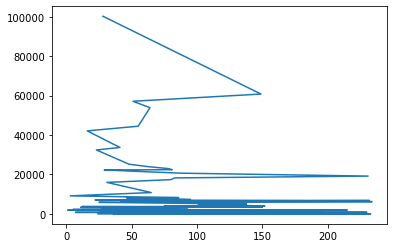

In [11]:
df.keydeveventtypeid.value_counts().sort_values(ascending=False).plot()

In [12]:
df.groupby(['gvkey','date','keydeveventtypeid'])['companyname'].count().sort_values(ascending=False).head(10)

gvkey   date        keydeveventtypeid
105547  2010-03-26  87.0                 244
        2010-01-26  87.0                 202
        2010-04-27  87.0                 190
        2010-02-23  87.0                 188
        2010-06-25  87.0                 126
271015  2010-03-22  75.0                 123
105547  2010-05-25  87.0                 112
207353  2010-03-22  75.0                 108
105547  2010-09-27  87.0                  70
        2010-07-23  87.0                  67
Name: companyname, dtype: int64

<AxesSubplot:xlabel='gvkey'>

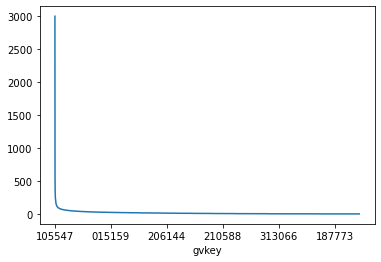

In [13]:
df.groupby(['gvkey'])['keydeveventtypeid'].count().sort_values(ascending=False).plot()

# Sentiment

In [14]:
df.isna().sum()

keydevid             0
companyname          0
gvkey                0
headline             0
situation            0
keydeveventtypeid    0
eventtype            0
dtype: int64

In [15]:
analyser = SentimentIntensityAnalyzer()

def get_sentiment(review, **kwargs):
    sentiment_scores = [analyser.polarity_scores(sentence) for sentence in review.split('.')]
    sentiment_scores = [(item['pos'], item['neg']) for item in sentiment_scores]
    pos, neg = list(zip(*sentiment_scores))
    return np.mean(pos), np.std(pos), np.mean(neg), np.std(neg)

sentiment = df['situation'].progress_apply(get_sentiment)
sentiment = list(zip(*sentiment))
df['pos_mean'] = sentiment[0]
df['pos_std'] = sentiment[1]
df['neg_mean'] = sentiment[2]
df['neg_std'] = sentiment[3]

  0%|          | 0/834206 [00:00<?, ?it/s]

In [16]:
df

,keydevid,companyname,gvkey,headline,situation,keydeveventtypeid,eventtype,pos_mean,pos_std,neg_mean,neg_std
date,,,,,,,,,,,
2010-01-01,83821114.0,"Cardinal Health, Inc.",002751,Memphis Internal Medicine PLLC Subleases the N...,Memphis Internal Medicine PLLC has signed an e...,23.0,Client Announcements,0.000000,0.000000,0.0000,0.000000
2010-01-01,83821109.0,The Coca-Cola Company,003144,The Coca-Cola Company Promotes Kathleen Ciaram...,The Coca-Cola Company has announced that Kathl...,16.0,Executive/Board Changes - Other,0.045600,0.055938,0.0000,0.000000
2010-01-01,84133417.0,Ford Motor Company,004839,Ford Motor Co. to Reduce Production in Europe,Ford Motor Co. will cut production in Europe i...,21.0,Discontinued Operations/Downsizings,0.000000,0.000000,0.0722,0.094018
2010-01-01,84655520.0,Siemens Water Technologies Corp.,008015,Siemens Water Technologies Corp. acquired Indu...,Siemens Water Technologies Corp. acquired Indu...,81.0,M&A Transaction Closings,0.000000,0.000000,0.0000,0.000000
2010-01-01,84159853.0,Shell plc,012384,Royal Dutch Shell plc Moves Closer to Chukchi ...,Royal Dutch Shell plc has secured an important...,41.0,Product-Related Announcements,0.078000,0.097069,0.0000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
2010-12-31,117717582.0,Beaumont Select Corporations Inc.,105560,Beaumont Select Corps. Inc. Announces Executiv...,Beaumont Select Corps. Inc. announced that it ...,16.0,Executive/Board Changes - Other,0.013333,0.029814,0.0000,0.000000
2010-12-31,117715312.0,Suncor Energy Inc.,015070,Parkland Income Fund Receives Notice from Sunc...,"Parkland Income Fund announced that, as expect...",23.0,Client Announcements,0.088750,0.089122,0.0000,0.000000
2010-12-31,117684828.0,Engro Corporation Limited,202033,EnGro Corporation Limited Opens Single Train U...,Engro Corporation Limited has started producti...,31.0,Business Expansions,0.075600,0.095200,0.0502,0.068709


In [17]:
# Topic Modelling

In [18]:
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

my_stopwords = nltk.corpus.stopwords.words('english')
word_rooter = nltk.stem.snowball.PorterStemmer(ignore_stopwords=False).stem
my_punctuation = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~•@'

# cleaning master function
def clean_tweet(tweet, bigrams=False):
    tweet = tweet.lower() # lower case
    tweet = re.sub('['+my_punctuation + ']+', ' ', tweet) # strip punctuation
    tweet = re.sub('\s+', ' ', tweet) #remove double spacing
    tweet = re.sub('([0-9]+)', '', tweet) # remove numbers
    tweet_token_list = [word for word in tweet.split(' ')
                            if word not in my_stopwords] # remove stopwords

    tweet_token_list = [word_rooter(word) if '#' not in word else word
                        for word in tweet_token_list] # apply word rooter
    if bigrams:
        tweet_token_list = tweet_token_list+[tweet_token_list[i]+'_'+tweet_token_list[i+1]
                                            for i in range(len(tweet_token_list)-1)]
    tweet = ' '.join(tweet_token_list)
    return tweet

df['clean_situation'] = df['situation'].progress_apply(clean_tweet)

  0%|          | 0/834206 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
stopwords_nltk=set(stopwords.words('english'))
wordnet_lemmatizer = WordNetLemmatizer()
stopwords_nltk=set(stopwords.words('english'))
word_tokenizer=RegexpTokenizer(r'\w+')


def tokenize_text(version_desc):
    lowercase=version_desc.lower()
    text = wordnet_lemmatizer.lemmatize(lowercase)
    tokens = word_tokenizer.tokenize(text)
    return tokens


vec_words = CountVectorizer(tokenizer=tokenize_text,stop_words=stopwords_nltk,decode_error='ignore')
total_features_words = vec_words.fit_transform(df['clean_situation'])

C:\Users\Hatricano\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['doe', 'ha', 'wa'] not in stop_words.
  warnings.warn(


In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
number_of_topics = 10
model = LatentDirichletAllocation(n_components=number_of_topics, random_state=0)
model.fit(total_features_words)

In [ ]:
def display_topics(model, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["Topic %d words" % (topic_idx)]= ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
        topic_dict["Topic %d weights" % (topic_idx)]= ['{:.1f}'.format(topic[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)

In [ ]:
no_top_words = 10
display_topics(model, tf_feature_names, no_top_words)